In [0]:
# [연습]_colab_bert_finetuning.ipynb
# 200102(목) 12:17~
# 천성욱

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install transformers==2.2

     |████████████████████████████████| 368kB 8.7MB/s 
     |████████████████████████████████| 860kB 65.6MB/s 
     |████████████████████████████████| 1.0MB 30.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=c16010f7d3fc1ebd3232df05b6f4b84799f9e8521a860d79000c1c04069772e8
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
# from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

Using TensorFlow backend.


In [0]:
tor_odic_weights = torch.load('/content/drive/My Drive/금융문자/모델링/model_KorBERT(ETRI)/1_bert_download_001_bert_morp_pytorch/001_bert_morp_pytorch/pytorch_model.bin')
dic_weights = dict(tor_odic_weights)

In [0]:
d_weight_new = dict()
int_lcnt_f = len(list(dic_weights.items())) -8    # BERT 모델 부분만 로드하기 위해서 8을 빼야한다.
for idx, (k, v) in enumerate(dic_weights.items()):
    if idx ==  int_lcnt_f:
        break
    print(k[5:])
    d_weight_new[k[5:]] = v

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [0]:
from collections import OrderedDict
odic_weight_new = OrderedDict(d_weight_new)
print(list(tor_odic_weights.items())[0])
print(list(tor_odic_weights.items())[0][1].shape)

('bert.embeddings.word_embeddings.weight', tensor([[-0.0276,  0.0102, -0.0276,  ...,  0.0029, -0.0093, -0.0042],
        [-0.0470,  0.0217, -0.0154,  ..., -0.0391,  0.0253,  0.0215],
        [-0.0147, -0.0300, -0.0310,  ..., -0.0107, -0.0058,  0.0222],
        ...,
        [-0.0589, -0.0076,  0.0200,  ...,  0.0097, -0.0124,  0.0145],
        [-0.0356, -0.0602, -0.0140,  ...,  0.0230, -0.0017, -0.0488],
        [-0.0531, -0.0201, -0.0196,  ..., -0.0237, -0.0130, -0.0030]]))
torch.Size([30349, 768])


In [0]:
from transformers import BertModel
from transformers import BertConfig
model_bert = BertModel(BertConfig(vocab_size_or_config_json_file=30349))
model_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30349, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
model_bert.load_state_dict(odic_weight_new)

<All keys matched successfully>

# classifier 레이어 합치기(진행중)

In [0]:
import torch.nn as nn
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [0]:
device = torch.device("cuda:0")

In [0]:
model = BERTClassifier(model_bert,  dr_rate=0.1).to(device)

In [0]:
!nvidia-smi    # 1183MiB 차지

Thu Jan  2 03:22:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |   1183MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 데이터 로드 및 전처리

In [0]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
import pandas as pd
path_base = '/content/drive/My Drive/금융문자/데이터/'
train = pd.read_csv(path_base + "sam60K_lvDist_0_82222_1_whole.csv", encoding='utf-8')
print(train.shape)

(60037, 7)


In [0]:
import re
re_pat_space = re.compile('\s{2,}')
re_pat_space.sub('g', '안녕  하세       요')
re_pat_words = re.compile('[^가-힣a-zA-Z0-9\s]')
re_pat_words.findall("녕  하세       요")
re_pat_XX_XXX = re.compile('X{2,}')
print(re_pat_XX_XXX.findall('XX고객님 XXX은행입니다. 안녕  하세       요X'))
re_pat_XX_XXX.sub('', 'XX고객님 XXX은행입니다. 안녕  하세       요X')

['XX', 'XXX']


'고객님 은행입니다. 안녕  하세       요X'

In [0]:
train['text'] = train['text'].apply(lambda x: re_pat_XX_XXX.sub(' ', re_pat_space.sub(' ', re_pat_words.sub('', x))))
train#['text']

,id,year_month,text,smishing,prep,len,lvDist
0,303496,2018-09,,0,NaN,0,1.000000
1,147557,2017-08,,0,,1,1.000000
2,257777,2018-04,0415 1422 카드스마트 710000잔액4869889,0,04151422 카드스마트 710000잔액4869889,31,0.967742
3,84368,2017-05,0전화하셔서0번누르시면상담원연결됩니다사용자계약번호확인해주세요,0,0전화하셔서0번누르시면상담원연결됩니다사용자계약번호확인해주세요,34,0.947368
4,81268,2017-05,1 입니다감사합니다 은행 올림,0,1 입니다감사합니다 은행 올림,17,0.911765
...,...,...,...,...,...,...,...
60032,308804,2018-10,햇살론대출 지원금융센터 수탁법인 투빅플러스2018년 현재 정부지원 자금을 통해 ...,1,햇살론대출지원금융센터 수탁법인투빅플러스2018년현재정부지원자금을통해하반기채무통합대환...,649,0.000000
60033,302073,2018-09,햇살론대출 지원금융센터 하나 2018년 현재 정부지원 자금을 통해 하반기 채무통합대...,1,햇살론대출지원금융센터하나 2018년현재정부지원자금을통해하반기채무통합대환상품추가상품개...,642,0.016949
60034,329779,2018-11,햇살론대출 지원금융센터 하나 2018년 현재 정부지원 자금을 통해 하반기 채무통합대...,1,햇살론대출지원금융센터하나 2018년현재정부지원자금을통해하반기채무통합대환상품추가상품개...,632,0.015576
60035,313242,2018-10,햇살론대출 지원금융센터 하나 수탁법인 하나채움2018년 현재 정부지원 자금을 통해...,1,햇살론대출지원금융센터하나 수탁법인하나채움2018년현재정부지원자금을통해하반기채무통합대...,650,0.027692


0    1
1    0
2    0
3    0
4    0
Name: smishing, dtype: int64


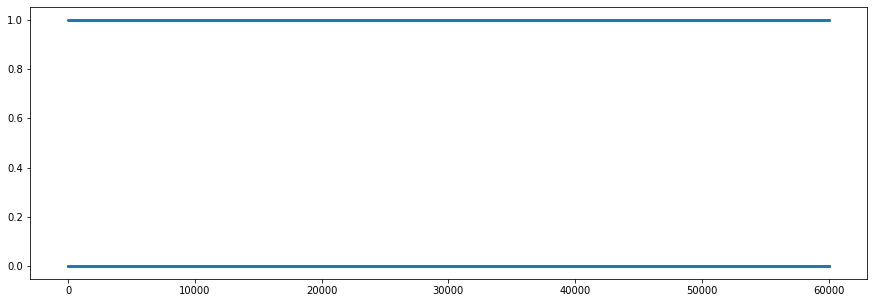

In [0]:
import matplotlib.pyplot as plt
train_rand = train.sample(frac=1, random_state=2020).reset_index()
print(train_rand['smishing'].head())
plt.figure(figsize=(15,5))
plt.scatter(train_rand['smishing'].indexㅠ.values, train_rand['smishing'].values, s=1)
plt.show()

In [0]:
# 리뷰 문장 추출
sentences = train_rand['text']
print(sentences[:3])
print(len(sentences))

0    광고 현명한 대출과 현명한 신용관리어느새 성큼 다가온 12월의 계절을 맞아 당사 상...
1                 포일 거래감사합니다 고객만족도 조사시 매우동의와 추천 칭찬해주세요
2     고객님을 위한 연말 환율우대 이벤트즐거운 연말 해외여행 계획이 있으시다면 내외동지...
Name: text, dtype: object
60037


In [0]:
import re
def f_re_pat(x):
#     print('before :', x)
    re_pat_ending = re.compile('(니다)|(세요)|(시오)')
    idx = 0
    for i in range(10):
#         print(idx, x[idx:])
        tmp_search = re_pat_ending.search(x[idx:])
        if tmp_search!=None:
            idx = tmp_search.end() +idx
            x = x[:idx] + ' [SEP]' + x[idx:]
#             print('after  :', x)
            idx += 6    # len(' [SEP]')
        else:
#             print('None')
            break
    if x[-6:] != ' [SEP]':    # 마지막 문장을 if문으로 판단하여, [SEP]를 넣어준다.
        x = x + ' [SEP]'
    return x
f_re_pat(train['text'][2])
# f_re_pat('안녕하세요. 입니다.')

' 0415 1422 카드스마트 710000잔액4869889 [SEP]'

In [0]:
import time
time_i = time.time()
sentences = sentences.apply(f_re_pat).values
print(sentences[:5])
print(time.time() - time_i)

['광고 현명한 대출과 현명한 신용관리어느새 성큼 다가온 12월의 계절을 맞아 당사 상품의 자격기준이 보다 완화되어 상품에 대해 고객님께 간단하게 정보를 전달드립니다 [SEP]경제성장률 마이너스 임금 상승률 제로 소비자 물가지수 상승 모두가 동감하는 현재 상황입니다 [SEP] 경제가 어렵다고 소비와 지출이 없을 순 없습니다 [SEP] 다만 똑똑한 소비와 똑똑한 지출로 마이너스의 함정에 빠지지 않도록 해야 합니다 [SEP]신청방법   터치하셔서 문자로 상담 또는 00시 00분 상담이라고 답장을 보내주시거나 전화를 주시면 친절하고 안전한 상담으로 도움드리겠습니다 [SEP]카카오톡 상담서비스 시행중 citibankloan친구추가 후 상담신청 은행 상품의 특징1 당사 거래가 없으셔도 진행가능2 시중은행권보다 높은한도3 부채가 많다면 부채 통합상품으로 전환 가능4 원리금 균등방식을 이자만 납입하는 만기일시로 전환 가능5 가상 조회를 통해 한도 및 금리를 한 번에 확인 가능 은행 상품안내1 직장인 신용상품한도 최대 1억 4000만 원까지금리 최저 297자격  은행 자체 등급과 기업 리스트에 따라 차등 적용2 채무통합 전환상품한도 연봉 대비 300까지금리 최저 297자격  은행 자체 등급과 기업 리스트에 따라 차등 적용3 새 희망 홀씨한도 최대 3000만 원금리 86812자격 연소득 4500만 원 이하 고객 대상으로 당사 자체 등급에 따라 차등 적용이런 분들께 권해드립니다 [SEP]1 시중은행권에서 기존한도를 모두 사용 중이신 분2 기대출의 원리금 균등방식으로 인해 월 납입금액이 부담스러우신 분3 총 부채금액은 작으나 부채건수가 많아서 관리가 안 되시는 분4 이제라도 대출로 인한 신용등급 관리 및 상승에 관심이 있으신 분신청방법   터광고  [SEP]'
 ' 포일 거래감사합니다 [SEP] 고객만족도 조사시 매우동의와 추천 칭찬해주세요 [SEP]'
 ' 고객님을 위한 연말 환율우대 이벤트즐거운 연말 해외여행 계획이 있으시다면 내외동지점과 함께 해주세요 [SEP]주요통화80달

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [0]:
import time
time_i = time.time()
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])
print(time.time() - time_i)

광고 현명한 대출과 현명한 신용관리어느새 성큼 다가온 12월의 계절을 맞아 당사 상품의 자격기준이 보다 완화되어 상품에 대해 고객님께 간단하게 정보를 전달드립니다 [SEP]경제성장률 마이너스 임금 상승률 제로 소비자 물가지수 상승 모두가 동감하는 현재 상황입니다 [SEP] 경제가 어렵다고 소비와 지출이 없을 순 없습니다 [SEP] 다만 똑똑한 소비와 똑똑한 지출로 마이너스의 함정에 빠지지 않도록 해야 합니다 [SEP]신청방법   터치하셔서 문자로 상담 또는 00시 00분 상담이라고 답장을 보내주시거나 전화를 주시면 친절하고 안전한 상담으로 도움드리겠습니다 [SEP]카카오톡 상담서비스 시행중 citibankloan친구추가 후 상담신청 은행 상품의 특징1 당사 거래가 없으셔도 진행가능2 시중은행권보다 높은한도3 부채가 많다면 부채 통합상품으로 전환 가능4 원리금 균등방식을 이자만 납입하는 만기일시로 전환 가능5 가상 조회를 통해 한도 및 금리를 한 번에 확인 가능 은행 상품안내1 직장인 신용상품한도 최대 1억 4000만 원까지금리 최저 297자격  은행 자체 등급과 기업 리스트에 따라 차등 적용2 채무통합 전환상품한도 연봉 대비 300까지금리 최저 297자격  은행 자체 등급과 기업 리스트에 따라 차등 적용3 새 희망 홀씨한도 최대 3000만 원금리 86812자격 연소득 4500만 원 이하 고객 대상으로 당사 자체 등급에 따라 차등 적용이런 분들께 권해드립니다 [SEP]1 시중은행권에서 기존한도를 모두 사용 중이신 분2 기대출의 원리금 균등방식으로 인해 월 납입금액이 부담스러우신 분3 총 부채금액은 작으나 부채건수가 많아서 관리가 안 되시는 분4 이제라도 대출로 인한 신용등급 관리 및 상승에 관심이 있으신 분신청방법   터광고  [SEP]
['광', '##고', '현', '##명한', '대', '##출', '##과', '현', '##명한', '신', '##용', '##관', '##리', '##어', '##느', '##새', '성', '##큼', '다', '##가'

In [0]:
# 라벨 추출
labels = train_rand['smishing'].values
print(labels)

[1 0 0 ... 1 0 1]


## token2id, padding, attention masking

In [0]:
import time
time_i = time.time()
# 입력 토큰의 최대 시퀀스 길이

MAX_LEN = 192#128#512#128#512#191227(금)_01   #128191226(목)

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(time.time() - time_i)
input_ids[0]

10.207472562789917


array([  8903,  11664,   9978,  68414,   9069,  52363,  11882,   9978,
        68414,   9487,  24974,  20595,  12692,  12965, 118760, 119031,
         9434, 119328,   9056,  11287,  37093,  16367,  10459,   8887,
        58931,  10622,   9256,  16985,   9067,  12945,   9414,  52951,
        10459,   9651,  45465,  12310,  54867,  10739, 106154,   9591,
        18227,  16855,   9414,  52951,  10530,  33378,   8888, 118617,
       108578, 118683,   8845,  24989,  17594,   9670,  91693,   9665,
        89851,  15001,  35115,  48345,    102,   8885,  17730,  17138,
        13890,  88350,   9246,  10739,  70162,  12605,   9644,  40032,
         9414,  48210,  88350,   9672,  11261,   9448,  29455,  13764,
         9299,  69023,  15891,   9414,  48210,  29414,  11287,   9095,
       105197,  12178,  26565,   9414,  65649,  58303,  48345,    102,
         8885,  54480,   9546, 118879,  85634,   9448,  29455,  12638,
         9706,  52363,  10739,   9555,  10622,   9462,   9555, 119081,
      

In [0]:
import time
time_i = time.time()
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(len(attention_masks[0]))
print(attention_masks[0])
print(time.time() - time_i)

192
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
6.5240747928619385


In [0]:
# 훈련셋과 검증셋으로 분리
nb_samples = 32*4
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids[:nb_samples],
                                                                                    labels[:nb_samples], 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks[:nb_samples], 
                                                       input_ids[:nb_samples],
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([  9670,  30858, 119121, 108578, 118957,  11664,   8863,  37388,  14523,
         16323, 119049,  12424,   9708,  71013,  11467,   8848,  12945,  33188,
         48345,    102,   9655,  31503,  41693, 119119,   9899,  13890, 119153,
         67527,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [0]:
print(train_inputs[0].shape)
print(train_labels[0].shape)
print('len:', len(train_labels[0].shape))
print(train_masks[0].shape)
print(validation_inputs[0].shape)
print(validation_labels[0].shape)
print('len:', len(validation_labels[0].shape))
print(validation_masks[0].shape)

torch.Size([192])
torch.Size([])
len: 0
torch.Size([192])
torch.Size([192])
torch.Size([])
len: 0
torch.Size([192])


In [0]:
model

NameError: ignored

In [0]:
# 배치 사이즈
batch_size = 32#8#16#32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 모델 생성 및 하이퍼파라미터 설정

In [0]:
## Setting parameters
max_len = 128
batch_size = 32
warmup_ratio = 0
num_epochs = 3
max_grad_norm = 1
log_interval = 10
learning_rate =  2e-5

In [0]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8) # eps 0으로 나누는 것을 방지하기 위한 epsilon 값
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
# scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps=warmup_step, t_total=t_total) 원래이거였는데 바꿔줌
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc    

## 훈련 코드

In [0]:
from tqdm import tqdm, tqdm_notebook
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids,  label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

NameError: ignored